# Predictive Quality Control for Manufacturing

## 1. Setup and Libraries

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

## 2. Data Preprocessing

In [2]:
# Load dataset
file_path = 'processData.csv'  # Path to your dataset
data = pd.read_csv(file_path)

# Check for categorical columns and encode them if necessary
from sklearn.preprocessing import LabelEncoder
for column in data.select_dtypes(include=['object']).columns:
    if data[column].dtype == 'object':
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Separate features (X) and target (y)
X = data.drop(columns=['y1', 'y2'])  # Assuming 'y1' and 'y2' are target columns
y = data[['y1', 'y2']]  # Adjust this as needed

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Perform Clustering (K-Means)

In [3]:
# Apply K-Means Clustering to the training data
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters
clusters_train = kmeans.fit_predict(X_train_scaled)

# Add the cluster label as a new feature to the training set
X_train_scaled = np.column_stack((X_train_scaled, clusters_train))

# Repeat for test set
clusters_test = kmeans.predict(X_test_scaled)
X_test_scaled = np.column_stack((X_test_scaled, clusters_test))

# Create a DataFrame with cluster labels
X_train_with_clusters = pd.DataFrame(X_train_scaled, columns=X.columns.tolist() + ['cluster'])
X_test_with_clusters = pd.DataFrame(X_test_scaled, columns=X.columns.tolist() + ['cluster'])

## 4. Train Regression Model

In [4]:
# Train a linear regression model (or polynomial regression, etc.)
model = LinearRegression()
model.fit(X_train_with_clusters, y_train)

# Save the model for future use
joblib.dump(model, 'clustered_tension_prediction_model.pkl')

# Make predictions
y_pred = model.predict(X_test_with_clusters)

## 5. Model Evaluation

In [5]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Model Performance: MSE = {mse:.4f}, R² Score = {r2:.4f}')

# Additional metrics for each cluster (if necessary)
for cluster_id in np.unique(clusters_train):
    print(f'\nEvaluating for Cluster {cluster_id}...')

    # Separate data by cluster
    cluster_mask = (clusters_test == cluster_id)
    y_test_cluster = y_test[cluster_mask]
    y_pred_cluster = y_pred[cluster_mask]
    
    mse_cluster = mean_squared_error(y_test_cluster, y_pred_cluster)
    r2_cluster = r2_score(y_test_cluster, y_pred_cluster)
    
    print(f'Cluster {cluster_id}: MSE = {mse_cluster:.4f}, R² = {r2_cluster:.4f}')

Model Performance: MSE = 0.4921, R² Score = 0.4767

Evaluating for Cluster 0...
Cluster 0: MSE = 0.3351, R² = -0.1685

Evaluating for Cluster 1...
Cluster 1: MSE = 0.5344, R² = 0.2971

Evaluating for Cluster 2...
Cluster 2: MSE = 0.6115, R² = 0.1880


## 6. Visualizations

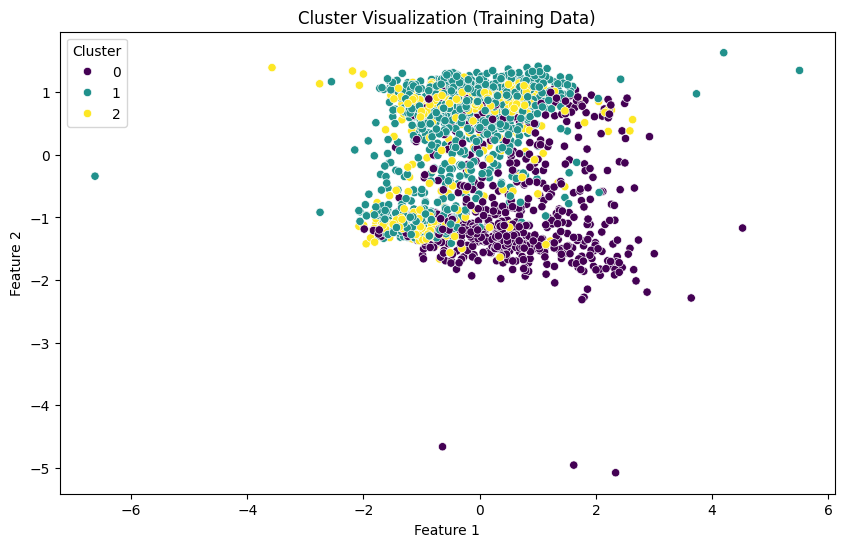

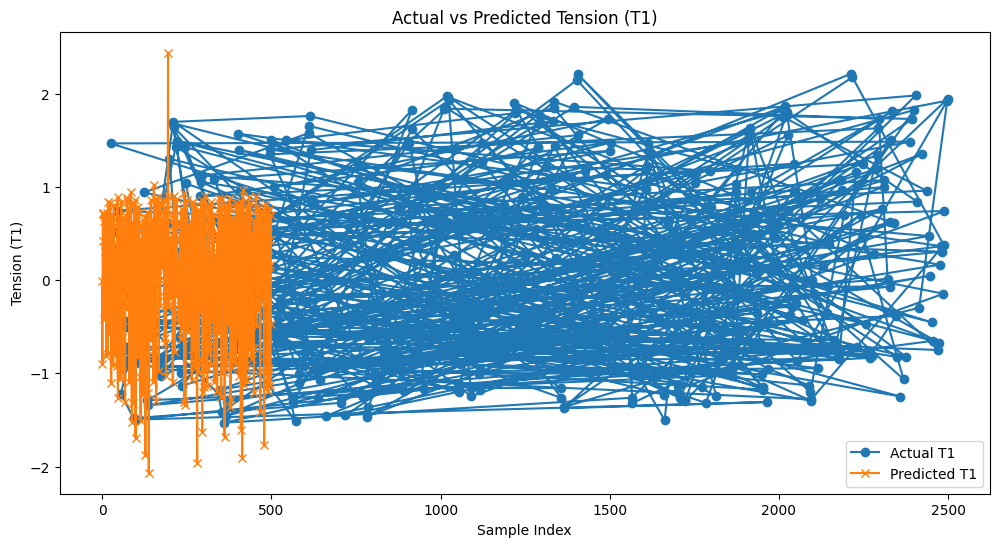

In [6]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_with_clusters.iloc[:, 0], y=X_train_with_clusters.iloc[:, 1], hue=clusters_train, palette='viridis')
plt.title('Cluster Visualization (Training Data)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

# Plot the regression model's performance
plt.figure(figsize=(12, 6))
plt.plot(y_test['y1'], label='Actual T1', marker='o')
plt.plot(y_pred[:, 0], label='Predicted T1', marker='x')
plt.title('Actual vs Predicted Tension (T1)')
plt.xlabel('Sample Index')
plt.ylabel('Tension (T1)')
plt.legend()
plt.show()

# You can repeat the visualization for other metrics and clusters as needed

## 7. Additional Exploration

In [7]:
# Test with different numbers of clusters
for n_clusters in range(2, 6):
    print(f"\nTesting with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit KMeans on the training data
    clusters_train = kmeans.fit_predict(X_train_scaled)
    
    # Add cluster labels to the training data
    X_train_scaled_with_clusters = np.column_stack((X_train_scaled, clusters_train))
    
    # Fit the model on the training data with cluster labels
    model.fit(X_train_scaled_with_clusters, y_train)
    
    # Predict on the test data, adding the cluster labels to the test set
    clusters_test = kmeans.predict(X_test_scaled)  # Predict the clusters for the test data
    X_test_scaled_with_clusters = np.column_stack((X_test_scaled, clusters_test))  # Add clusters to X_test

    # Make predictions
    y_pred = model.predict(X_test_scaled_with_clusters)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')


Testing with 2 clusters...
MSE: 0.4920, R²: 0.4768

Testing with 3 clusters...
MSE: 0.4921, R²: 0.4767

Testing with 4 clusters...
MSE: 0.4814, R²: 0.4880

Testing with 5 clusters...
MSE: 0.4923, R²: 0.4765
